## Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import datetime
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.matcher import PhraseMatcher
from scipy.sparse import hstack
from scipy import sparse
from sklearn.model_selection import train_test_split
import os

# Flatten

In [2]:
def load_data():
    salaries = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/salaries.csv")
    posting = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/postings.csv")
    benefit = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/benefits.csv")
    job_industry = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/job_industries.csv")
    job_skill = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/job_skills.csv")
    industry = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/industries.csv")
    skill = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/skills.csv")
    companies = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/companies.csv")
    company_industries = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/company_industries.csv")
    employee_counts = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/INSY 695 - Enterprise Data Science/Group Project/Code/Merge/dataoriginal/employee_counts.csv")
    
    return salaries, posting, benefit, job_industry, job_skill, industry, skill, companies, company_industries, employee_counts

# --- Functions ---
def filter_salaries(df):
    """Filter out salary rows with missing min or max salary and print shape."""
    filtered = df[(df['min_salary'].notna()) & (df['max_salary'].notna())]
    print(filtered.shape)
    return filtered

def merge_posting(salaries, posting):
    """Merge salaries with postings on job_id and print shape."""
    merged = salaries.merge(posting, on="job_id", how="left")
    print(merged.shape)
    return merged

def merge_company(salary_posting, companies, company_industries, employee_counts):
    
    # keep only the latest employee counts
    employee_counts_latest = (
        employee_counts.sort_values('time_recorded')
        .drop_duplicates('company_id', keep='last')
        .drop(columns='time_recorded')
    )

    # keep one industry per company
    industry_single = (
        company_industries.groupby('company_id')['industry']
        .first()
        .reset_index()
    )

    # Merge companies + employee info
    merged = pd.merge(companies, employee_counts_latest, on='company_id', how='left')
    merged = pd.merge(merged, industry_single, on='company_id', how='left')

    # filter out incomplete company profiles
    final_company = merged[
        merged['industry'].notna() &
        merged['name'].notna() &
        (merged['name'].str.strip() != '')
    ]

    print("Final Company Profile:", final_company.shape)

    # Step 5: merge into job posting data
    merged_result = salary_posting.merge(final_company, on="company_id", how="left")
    print("Merged Salary+Posting+Company:", merged_result.shape)
    return merged_result

def process_job_industry(job_industry, industry):
    """Merge job_industry with industry names and print shape."""
    merged = job_industry.merge(industry, on="industry_id", how="left")
    print(merged.shape)
    return merged

def process_job_skill(job_skill, skill):
    """Merge job_skill with skill names and print shape."""
    merged = job_skill.merge(skill, on="skill_abr", how="left")
    print(merged.shape)
    return merged

def process_benefits(benefit):
    """Aggregate benefits by job_id and print shape."""
    aggregated =  benefit.groupby("job_id").agg({"inferred": list, "type": list}).reset_index()
    print(aggregated.shape)
    return aggregated

def flatten():
    # Load all datasets
    salaries, posting, benefit, job_industry, job_skill, industry, skill, companies, company_industries, employee_counts = load_data()
    print("Done Loading Files")
    
    # Process salary-related data
    salaries_filtered = filter_salaries(salaries)
    salary_posting = merge_posting(salaries_filtered, posting)
    salary_posting_company = merge_company(salary_posting, companies, company_industries, employee_counts)
    
    # Process job skill and industry data (if needed for further use)
    job_skill_name = process_job_skill(job_skill, skill)
    job_industry_name = process_job_industry(job_industry, industry)
    
    # Merge the salary info with job industry (using original job_industry as base)
    final = job_industry.merge(salary_posting_company, on="job_id", how="left")
    
    # Process and merge benefits
    benefit_inferred_type = process_benefits(benefit)
    final = final.merge(benefit_inferred_type, on="job_id", how="left")
    final = final[(final['salary_id'].notna())]
    
    # Write final output to CSV
    #final.to_csv("df_flat.csv", index=False)
    print(final.shape)

    return final

if __name__ == "__main__":
    df_flat = flatten()
    print("Flatten complete. 'df_flat.csv' has been created.")

Done Loading Files
(33947, 8)
(33947, 38)
(33947, 50)
(213768, 3)
(164808, 3)
(30023, 3)
(45823, 53)
Flatten complete. 'df_flat.csv' has been created.


# Cleaning

In [3]:
def clean(data):
    # Make an explicit copy of the dataframe
    data = data.copy()
    
    # Drop rows where either 'company_name' or 'title' is missing
    data = data.dropna(subset=['company_name', 'title', 'normalized_salary'])
    
    # Fill missing values
    data = data.assign(
        application_type=data['application_type'].fillna('UnknownApply'),
        formatted_experience_level=data['formatted_experience_level'].fillna('Other')
    )

    ###########################################################################################################################

    # USD Standardization
    currency_conversion = {
        'USD': 1.0,   # USD to USD (no change)
        'CAD': 0.74,  # 1 CAD = 0.74 USD
        'BBD': 0.50,  # 1 BBD = 0.50 USD
        'EUR': 1.08,  # 1 EUR = 1.08 USD
        'AUD': 0.66,  # 1 AUD = 0.66 USD
        'GBP': 1.26   # 1 GBP = 1.26 USD
    }
    
    # Use assign to avoid SettingWithCopyWarning
    data = data.assign(
        max_salary_in_usd=data['max_salary_y'] * data['currency_x'].map(currency_conversion),
        min_salary_in_usd=data['min_salary_y'] * data['currency_x'].map(currency_conversion)
    )

    # Standardize pay period to hourly
    pay_period_conversion = {
        'HOURLY': 1,           # No conversion needed
        'YEARLY': 1 / 2080,     # Convert yearly salary to hourly
        'MONTHLY': 1 / 173.33,  # Convert monthly salary to hourly
        'WEEKLY': 1 / 40,       # Convert weekly salary to hourly
        'BIWEEKLY': 1 / 80      # Convert biweekly salary to hourly
    }
    
    # Use assign for multiple columns at once
    data = data.assign(
        max_hourly_salary_in_usd=data['max_salary_in_usd'] * data['pay_period_x'].map(pay_period_conversion),
        min_hourly_salary_in_usd=data['min_salary_in_usd'] * data['pay_period_x'].map(pay_period_conversion)
    )
    
    data = data.assign(
        mean_hourly_salary_in_usd=(data['max_hourly_salary_in_usd'] + data['min_hourly_salary_in_usd']) / 2
    )

    ##### DATE TIME CONVERSIONS

    # Convert 'listed_time' to datetime and extract date and time
    liteddatetime = pd.to_datetime(data['listed_time'], unit='ms', utc=True)
    data = data.assign(
        ListedDate=liteddatetime.dt.date,
        ListedTime=liteddatetime.dt.time
    )
    
    # Convert 'expiry' to datetime and extract date and time
    expiryddatetime = pd.to_datetime(data['expiry'], unit='ms', utc=True)
    data = data.assign(
        ExpieryDate=expiryddatetime.dt.date,
        ExpieryTime=expiryddatetime.dt.time
    )
    
    # Convert 'original_listed_time' to datetime and extract date and time
    originaldatetime = pd.to_datetime(data['original_listed_time'], unit='ms', utc=True)
    data = data.assign(
        OriginalDate=originaldatetime.dt.date,
        OriginalTime=originaldatetime.dt.time
    )

    ###########################################################################################################################
    def clean_benefits(x):
        if isinstance(x, (list, tuple)):
            # Filter out any NaN values and clean each item
            cleaned = [str(item).strip().strip('"') for item in x if not pd.isna(item)]
            return cleaned
        else:

            if pd.isna(x):
                return []
            else:
                return [str(x).strip().strip('"')]

    data = data.assign(type_list=data['type'].apply(clean_benefits))

    unique_benefits = set(item for sublist in data['type_list'] for item in sublist)
    #print("Unique benefits:", unique_benefits)

    exploded = data.explode('type_list')

    dummies = exploded['type_list'].str.get_dummies()

    dummies = dummies.groupby(dummies.index).max()

    # Join the dummy columns back into the original DataFrame.
    data = data.join(dummies)

    data = data.drop(columns=['type', 'type_list'])

    ###########################################################################################################################

    ad0 = ['views', 'applies', 'remote_allowed', 'employee_count', 'company_size']
    data[ad0] = data[ad0].fillna(0)

    ###########################################################################################################################
    # Create binary column 'CompApplication'
    data = data.assign(
        CompApplication=data.apply(
            lambda row: 1 if pd.notnull(row['application_url']) and row['application_url'] != "" and str(row['company_name']).lower() in str(row['application_url']).lower() else 0,
            axis=1
        )
    )

    
    ###########################################################################################################################
    ##" Seniroity Level and other terms extraction"

    # # Extract job seniority level from title
    # data['seniority'] = data['title'].str.extract('(Junior|Senior|Lead|Principal|Chief|Director|VP|Head|Manager)')

    # # Create tech role indicator
    # data['is_tech_role'] = data['title'].str.contains('Engineer|Developer|Data Scientist|Programmer|Software', case=False).astype(int)

    # # Create management role indicator
    data['is_management'] = data['title'].str.contains('Manager|Director|Lead|Chief|Head', case=False).astype(int)

    ###########################################################################################################################
    ##" Dropping columns that are not needed for the analysis"
    
    dropColumns = ['closed_time', 'closed_time', 'expiry', 'listed_time', 'inferred', 'max_salary_y', 'min_salary_y', 'fips', 'original_listed_time']
    drop2 = ['med_salary_x', 'max_salary_x', 'min_salary_x', 'med_salary_y', 'currency_y', 'pay_period_y', 'pay_period_x', 'OriginalDate', 'OriginalTime', 'zip_code_x', 'posting_domain', 'name', 'skills_desc', 'application_url']
    
    data = data.drop(columns=dropColumns)
    data = data.drop(columns=drop2)
    
    ###########################################################################################################################
    ### Dumifying object

    # feature_column = 'extracted_skills'

    # # Convert string representations of lists into actual lists
    # data[feature_column] = data[feature_column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # # Create a set of all unique skills
    # all_features = set()
    # for features in data[feature_column]:
    #     if isinstance(features, list):
    #         all_features.update([f.lower() for f in features])  # Convert to lowercase
    
    # # Create binary columns for each unique skill
    # for feature in sorted(all_features):
    #     data[f'feature_{feature}'] = data[feature_column].apply(
    #         lambda x: 1 if isinstance(x, list) and feature in [f.lower() for f in x] else 0
    #     )
    

    # for col in data.select_dtypes(include=['object']).columns:
    #     data = pd.get_dummies(data, columns=[col], drop_first=True)

    ###########################################################################################################################
    ### drop all remaining missing values
    data = data.dropna()

    return data

In [4]:
df_clean = clean(df_flat)
print('Cleaning Done')

Cleaning Done


In [5]:
num_rows = df_clean.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 39958


# Text Analytics

### Description

In [6]:
def process_job_description_pipeline(dataclean):
    # --- Step 1: Merge and Preprocess Job Descriptions ---
    # Load spaCy's English model
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
    
    # Merge the two description columns into one full description
    dataclean['full_description'] = dataclean['description_x'].fillna('') + " " + dataclean['description_y'].fillna('')
    
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc 
                  if token.pos_ in ['NOUN', 'PROPN'] and token.is_alpha and not token.is_stop]
        return ' '.join(tokens)
    
    dataclean['cleaned_full_description'] = dataclean['full_description'].apply(clean_text)
    
    # --- Step 2: Candidate Keyword Extraction via TF-IDF ---
    tfidf_vectorizer_candidates = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix_candidates = tfidf_vectorizer_candidates.fit_transform(dataclean['cleaned_full_description'])
    feature_names = tfidf_vectorizer_candidates.get_feature_names_out()
    tfidf_scores = np.array(tfidf_matrix_candidates.sum(axis=0)).flatten()
    tfidf_word_scores = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)
    
    # Define banned words (generic words not representative of specific job assets)
    banned_words = set([
        "experience", "company", "candidate", "role", "skill", "job", "career",
        "industry", "organization", "people", "work", "business", "community", "year",
        "process", "method", "system", "result", "output", "quality", "standard", "support",
        "report", "metric", "knowledge", "firm", "level", "talent",
        "team", "client", "service", "customer", "project", "management", "product",
        "employee", "solution", "opportunity", "care",  "time", "benefit",
        "position", "program", "ability",  
        "staffing", "status", "life","world", "day", "office", "range",
        "manager", "employment", "requirement",
        "department", "division", "partner", "partnership", "relationship", "corporate",
        "internal", "external",
        "project management", "customer service", "team building", "business development", "need"
        "dynamic", "innovative", "proactive", "passionate", "motivated", "experienced", "success", "employer", "salary",
        "dedicated", "driven", "collaborative", "organized", "flexible", "ii", "chicago", "tool", "pay", "applicant", "compensation", "value", 'area'
    ])
    
    filtered_tfidf_word_scores = [(word, score) for word, score in tfidf_word_scores if word not in banned_words]
    top_n = 50
    top_candidates = [word for word, score in filtered_tfidf_word_scores[:top_n]]
    
    # --- Step 3: Extract Explicit Skills/Traits Using a Dictionary-Based Approach ---
    # Use the top candidates as the skills list.
    skills_list = top_candidates
    matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = [nlp.make_doc(skill) for skill in skills_list]
    matcher.add("SKILL", patterns)
    
    def extract_skills(text):
        doc = nlp(text)
        matches = matcher(doc)
        skills_found = set()
        for match_id, start, end in matches:
            span = doc[start:end]
            skills_found.add(span.text.lower())
        return list(skills_found)
    
    dataclean['extracted_skills'] = dataclean['full_description'].apply(extract_skills)
    
    # Create binary (dummy) features for each skill in skills_list.
    def create_skill_features(text, skills):
        features = {}
        for skill in skills:
            features[skill] = 1 if skill in text else 0
        return features
    
    skill_features = dataclean['full_description'].apply(lambda text: create_skill_features(text, skills_list))
    skills_df = pd.DataFrame(skill_features.tolist(), index=dataclean.index)
    
    # --- Step 4: Generate Contextual Features Using TF-IDF ---
    tfidf_vectorizer_context = TfidfVectorizer(max_features=50)
    tfidf_features_context = tfidf_vectorizer_context.fit_transform(dataclean['full_description'])
    
    # --- Step 5: Combine Feature Sets ---
    skills_sparse = sparse.csr_matrix(skills_df.values)
    combined_features = hstack([tfidf_features_context, skills_sparse])
    
    # --- Step 6: Append the Combined Features to a New Column ---
    combined_features_dense = combined_features.toarray()
    dataclean['combined_features'] = list(combined_features_dense)
    
    return dataclean, skills_df


data_clean_text_A, skills_df = process_job_description_pipeline(df_clean)
print(data_clean_text_A[['extracted_skills', 'combined_features']].head())



                                     extracted_skills  \
19  [technology, development, disability, growth, ...   
21  [plan, market, need, growth, account, training...   
22  [plan, market, need, growth, account, training...   
23  [plan, market, need, growth, account, training...   
24     [development, degree, market, group, software]   

                                    combined_features  
19  [0.0, 0.023679692232319555, 0.0644946261483019...  
21  [0.04257830520079149, 0.06871188262432658, 0.0...  
22  [0.04257830520079149, 0.06871188262432658, 0.0...  
23  [0.04257830520079149, 0.06871188262432658, 0.0...  
24  [0.0, 0.052739178697785154, 0.0, 0.54405559421...  


In [7]:
print(skills_df.columns)
# I called it skills but it is general inustry domain terms
# This gives us overal business vision while reducing dimensionality
# This process can be pushed further given more time and further insights can be extracted
# Project phase 2 will focuss on text extracttion and NLP enhancement + feature engineering enhancement
# This is a good for the POC

Index(['sale', 'health', 'technology', 'development', 'datum', 'information',
       'engineering', 'design', 'accounting', 'plan', 'application',
       'disability', 'communication', 'environment', 'healthcare', 'insurance',
       'marketing', 'patient', 'software', 'location', 'state', 'training',
       'member', 'market', 'operation', 'need', 'responsibility', 'group',
       'law', 'performance', 'qualification', 'degree', 'education', 'hour',
       'security', 'account', 'strategy', 'individual', 'resource', 'growth',
       'policy', 'family', 'practice', 'construction', 'culture', 'equipment',
       'store', 'safety', 'duty', 'brand'],
      dtype='object')


In [8]:
display(data_clean_text_A[['full_description', 'extracted_skills', 'combined_features']].head())

,full_description,extracted_skills,combined_features
19,GENERAL PURPOSE:Under the general direction of...,"[technology, development, disability, growth, ...","[0.0, 0.023679692232319555, 0.0644946261483019..."
21,Territory Sales Manager - Medical Sales\nMy cl...,"[plan, market, need, growth, account, training...","[0.04257830520079149, 0.06871188262432658, 0.0..."
22,Territory Sales Manager - Medical Sales\nMy cl...,"[plan, market, need, growth, account, training...","[0.04257830520079149, 0.06871188262432658, 0.0..."
23,Territory Sales Manager - Medical Sales\nMy cl...,"[plan, market, need, growth, account, training...","[0.04257830520079149, 0.06871188262432658, 0.0..."
24,"Our client, a financial services company, is l...","[development, degree, market, group, software]","[0.0, 0.052739178697785154, 0.0, 0.54405559421..."


### Title Text clean

In [9]:
def extract_title_clean(dataclean, top_n=10, banned_words=None, min_score_threshold=0.0):
    
    if banned_words is None:
        banned_words = {""}
    
    # Step 1: Compute global TF‑IDF scores for bigrams
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(dataclean['title'].fillna(''))
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    
    # Create a list of (bigram, score) pairs sorted by score (highest first)
    bigram_scores = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)
    
    # Build allowed candidate dictionary with exactly top_n bigrams
    allowed_bigrams = {}
    for bigram, score in bigram_scores:
        if bigram in banned_words or score < min_score_threshold:
            continue
        allowed_bigrams[bigram] = score
        if len(allowed_bigrams) >= top_n:
            break
    
    # Create a set of allowed bigrams for O(1) lookup
    allowed_bigram_set = set(allowed_bigrams.keys())
    
    def find_most_similar_bigram(title):
        """Find the most similar allowed bigram based on word overlap."""
        title_words = set(title.lower().split())
        max_overlap = 0
        best_bigram = list(allowed_bigrams.keys())[0]  # Default to highest TF-IDF bigram
        
        for bigram in allowed_bigrams:
            bigram_words = set(bigram.split())
            overlap = len(title_words & bigram_words)
            if overlap > max_overlap:
                max_overlap = overlap
                best_bigram = bigram
            elif overlap == max_overlap:
                # If same overlap, choose the one with higher TF-IDF score
                if allowed_bigrams[bigram] > allowed_bigrams[best_bigram]:
                    best_bigram = bigram
        
        return best_bigram
    
    def get_best_bigram(title):
        if pd.isna(title):
            return list(allowed_bigrams.keys())[0]  # Default to highest TF-IDF bigram
        
        title_lower = title.lower().strip()
        matching_candidates = []
        
        # First try exact matches
        for candidate in allowed_bigrams:
            pattern = r'\b' + re.escape(candidate).replace(r'\ ', r'\s+') + r'\b'
            if re.search(pattern, title_lower):
                matching_candidates.append(candidate)
        
        if matching_candidates:
            # Choose the candidate with the highest global TF‑IDF score
            return sorted(matching_candidates, key=lambda c: allowed_bigrams[c], reverse=True)[0]
        
        # If no exact matches, find the most similar allowed bigram
        return find_most_similar_bigram(title_lower)
    
    dataclean['TitleClean'] = dataclean['title'].apply(get_best_bigram)
    return dataclean

def higher_level_mapping(data):
    title_mapping = {
        # Project/Product Management
        "project manager": "Project/Product Management",
        "program manager": "Project/Product Management",
        "project coordinator": "Project/Product Management",
        "senior project": "Project/Product Management",
        "construction project": "Project/Product Management",
        "construction superintendent": "Project/Product Management",
        "product manager": "Project/Product Management",
        "senior product": "Project/Product Management",

        # Software Engineering
        "software engineer": "Software Engineering",
        "senior software": "Software Engineering",
        "development engineer": "Software Engineering",
        "network engineer": "Software Engineering",
        "security engineer": "Software Engineering",
        "systems engineer": "Software Engineering",
        "engineering manager": "Software Engineering",
        "project engineer": "Software Engineering",
        "field service": "Software Engineering",

        # Data & Analytics
        "data scientist": "Data & Analytics",
        "data analyst": "Data & Analytics",
        "data engineer": "Data & Analytics",
        "business analyst": "Data & Analytics",
        "financial analyst": "Data & Analytics",
        "senior data": "Data & Analytics",

        # Sales & Business Development
        "sales representative": "Sales & Business",
        "sales associate": "Sales & Business",
        "sales consultant": "Sales & Business",
        "sales manager": "Sales & Business",
        "business development": "Sales & Business",
        "sales executive": "Sales & Business",
        "account executive": "Sales & Business",
        "inside sales": "Sales & Business",
        "outside sales": "Sales & Business",
        "sales specialist": "Sales & Business",
        "sales development": "Sales & Business",
        "account manager": "Sales & Business",
        "store manager": "Sales & Business",
        "assistant store": "Sales & Business",
        "development representative": "Sales & Business",
        "development manager": "Sales & Business",

        # Customer Support
        "support specialist": "Customer Support",
        "customer service": "Customer Support",
        "service representative": "Customer Support",
        "technical support": "Customer Support",
        "service technician": "Customer Support",
        "maintenance technician": "Customer Support",
        "field service": "Customer Support",
        "information technology": "Customer Support",

        # Accounting & Finance
        "accounting manager": "Accounting & Finance",
        "staff accountant": "Accounting & Finance",
        "senior accountant": "Accounting & Finance",
        "financial advisor": "Accounting & Finance",
        "tax manager": "Accounting & Finance",
        "senior tax": "Accounting & Finance",
        "senior financial": "Accounting & Finance",
        "finance manager": "Accounting & Finance",
        "accounts payable": "Accounting & Finance",
        "accounts receivable": "Accounting & Finance",
        "payroll specialist": "Accounting & Finance",

        # Marketing
        "marketing specialist": "Marketing",
        "marketing manager": "Marketing",

        # Engineering & Manufacturing
        "manufacturing engineer": "Engineering",
        "design engineer": "Engineering",
        "quality engineer": "Engineering",
        "test engineer": "Engineering",
        "process engineer": "Engineering",
        "mechanical engineer": "Engineering",
        "electrical engineer": "Engineering",
        "engineer ii": "Engineering",
        "quality assurance": "Engineering",

        # Operations & HR
        "human resources": "Operations & HR",
        "resources manager": "Operations & HR",
        "operations manager": "Operations & HR",
        "operations specialist": "Operations & HR",
        "resources generalist": "Operations & HR",
        "administrative assistant": "Operations & HR",
        "assistant manager": "Operations & HR",
        "office manager": "Operations & HR", 
        "executive assistant": "Operations & HR",

        # Medical & Healthcare
        "registered nurse": "Medical & Healthcare",
        "nurse practitioner": "Medical & Healthcare",
        "physical therapist": "Medical & Healthcare",
        "medical assistant": "Medical & Healthcare",
        "mental health": "Medical & Healthcare",
        "home health": "Medical & Healthcare",
        "travel rn": "Medical & Healthcare",
        "med surg": "Medical & Healthcare",
        "nurse rn": "Medical & Healthcare",

        # Legal & Real Estate
        "legal assistant": "Legal & Real Estate",
        "associate attorney": "Legal & Real Estate",
        "litigation associate": "Legal & Real Estate",
        "real estate": "Legal & Real Estate",

        # Senior Leadership & Management
        "senior manager": "Senior Leadership",
        "senior director": "Senior Leadership",
        "associate director": "Senior Leadership",
        "vice president": "Senior Leadership",
        "general manager": "Senior Leadership",

        # Logistics & Supply Chain
        "warehouse associate": "Logistics & Supply Chain",
        "supply chain": "Logistics & Supply Chain",

        # Other Roles
        "entry level": "Other",
        "2nd shift": "Other"
    }

    #### Verify Mapping###
    mapped_title = set(title_mapping.keys())
    existing_title = set(data["TitleClean"].unique())
    unmapped_title = existing_title - mapped_title
    print("Titles not mapped:\n")
    for i in unmapped_title:
        print(i)

    data["title_family"] = data["TitleClean"].map(title_mapping)
    print(len(data["title_family"].unique()))


    return data


# Example usage:
TOP_N = 100
data_clean_text_B = extract_title_clean(data_clean_text_A, top_n=TOP_N)
data_clean_text_C  = higher_level_mapping(data_clean_text_B)




Titles not mapped:

14


In [10]:
# # Verify we have exactly TOP_N unique values
# n_unique = data_clean_text_C['TitleClean'].nunique()
# print(f"Number of unique values in TitleClean: {n_unique}")
# print(data_clean_text_C[['title', 'TitleClean']])


# n_unique2 = data_clean_text_C['title_family'].nunique()
# print(f"Number of unique values in title_family: {n_unique2}")
# print(data_clean_text_C[['title', 'title_family']])

# empty_percentage = (data_clean_text_C['TitleClean'].isna() | (data_clean_text_C['TitleClean'].str.strip() == "")).mean() * 100
# print(f"Percentage of empty values in 'TitleClean': {empty_percentage:.2f}%")

# titlelist = data_clean_text_C['TitleClean'].unique().tolist()
# print(titlelist)

# print(f"There is a total of {len(titlelist)} unique titles in the 'TitleClean' column.")

In [14]:
#data_clean_text_C.to_csv("Final_DataFrame.csv", index=False)
DataFinalLoad = data_clean_text_C.copy()
print("Initial Processing Done")
print("Steps accomplished: \n 1. Data Load \n 2. Data Cleaning \n 3. Data Processing \n 4. Text Analytics \n 5. Data Export")

Initial Processing Done
Steps accomplished: 
 1. Data Load 
 2. Data Cleaning 
 3. Data Processing 
 4. Text Analytics 
 5. Data Export


# Final Load

In [15]:
DataFinalLoad = pd.read_csv("Final_DataFrame.csv")

In [16]:
DataFinalLoad

,job_id,industry_id,salary_id,currency_x,compensation_type_x,company_name,title,description_x,location,company_id,...,Tuition assistance,Vision insurance,CompApplication,is_management,full_description,cleaned_full_description,extracted_skills,combined_features,TitleClean,title_family
19,3884431523,56,3.0,USD,BASE_SALARY,Energy Fuels Inc,Mine Foreman,GENERAL PURPOSE:Under the general direction of...,Greater Flagstaff Area,947812.0,...,0,1,0,0,GENERAL PURPOSE:Under the general direction of...,purpose direction superintendent position vers...,"[technology, development, disability, growth, ...","[0.0, 0.023679692232319555, 0.0644946261483019...",project manager,Project/Product Management
21,3884911725,12,4.0,USD,BASE_SALARY,"Direct Sales Recruiting, LLC",Territory Sales - Medical Sales - Long Island,Territory Sales Manager - Medical Sales\nMy cl...,"Hempstead, NY",766849.0,...,0,0,0,0,Territory Sales Manager - Medical Sales\nMy cl...,territory sale manager sale client leader devi...,"[plan, market, need, growth, account, training...","[0.04257830520079149, 0.06871188262432658, 0.0...",sales representative,Sales & Business
22,3884911725,17,4.0,USD,BASE_SALARY,"Direct Sales Recruiting, LLC",Territory Sales - Medical Sales - Long Island,Territory Sales Manager - Medical Sales\nMy cl...,"Hempstead, NY",766849.0,...,0,0,0,0,Territory Sales Manager - Medical Sales\nMy cl...,territory sale manager sale client leader devi...,"[plan, market, need, growth, account, training...","[0.04257830520079149, 0.06871188262432658, 0.0...",sales representative,Sales & Business
23,3884911725,15,4.0,USD,BASE_SALARY,"Direct Sales Recruiting, LLC",Territory Sales - Medical Sales - Long Island,Territory Sales Manager - Medical Sales\nMy cl...,"Hempstead, NY",766849.0,...,0,0,0,0,Territory Sales Manager - Medical Sales\nMy cl...,territory sale manager sale client leader devi...,"[plan, market, need, growth, account, training...","[0.04257830520079149, 0.06871188262432658, 0.0...",sales representative,Sales & Business
24,3887473220,43,5.0,USD,BASE_SALARY,Motion Recruitment,Project Manager,"Our client, a financial services company, is l...","New York, United States",5887.0,...,0,0,0,1,"Our client, a financial services company, is l...",client service company non project manager tea...,"[development, degree, market, group, software]","[0.0, 0.052739178697785154, 0.0, 0.54405559421...",project manager,Project/Product Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164789,3906264345,17,40779.0,USD,BASE_SALARY,"TalentBurst, an Inc 5000 company",Quality Engineer,Position: Quality Engineer I/IILocation: Irvin...,"Irvine, CA",122451.0,...,0,1,0,0,Position: Quality Engineer I/IILocation: Irvin...,position quality engineer iilocation irvine mo...,"[member, degree, state, environment, engineeri...","[0.02752572253168699, 0.022210186699867747, 0....",quality engineer,Engineering
164790,3906264345,15,40779.0,USD,BASE_SALARY,"TalentBurst, an Inc 5000 company",Quality Engineer,Position: Quality Engineer I/IILocation: Irvin...,"Irvine, CA",122451.0,...,0,1,0,0,Position: Quality Engineer I/IILocation: Irvin...,position quality engineer iilocation irvine mo...,"[member, degree, state, environment, engineeri...","[0.02752572253168699, 0.022210186699867747, 0....",quality engineer,Engineering
164791,3906264345,12,40779.0,USD,BASE_SALARY,"TalentBurst, an Inc 5000 company",Quality Engineer,Position: Quality Engineer I/IILocation: Irvin...,"Irvine, CA",122451.0,...,0,1,0,0,Position: Quality Engineer I/IILocation: Irvin...,position quality engineer iilocation irvine mo...,"[member, degree, state, environment, engineeri...","[0.02752572253168699, 0.022210186699867747, 0....",quality engineer,Engineering
164802,3902866633,62,40783.0,USD,BASE_SALARY,Wabtec Corporation,Warehouse Associate WMS 3W,Wabtec Corporation is a leading global provide...,"Fort Worth, TX",8239496.0,...,0,0,0,0,Wabtec Corporation is a leading global provide...,cor

In [17]:
DataFinalLoad.shape

(39958, 61)

In [18]:
datatest = DataFinalLoad.copy()
na_percent = DataFinalLoad.isnull().mean() * 100

# Filter columns that have any missing values
na_percent = na_percent[na_percent > 0]

# Print the result, sorted by percentage in descending order
for col, pct in na_percent.sort_values(ascending=False).items():
    print(f"{col} ---> {pct:.2f}% missing")

<Axes: >

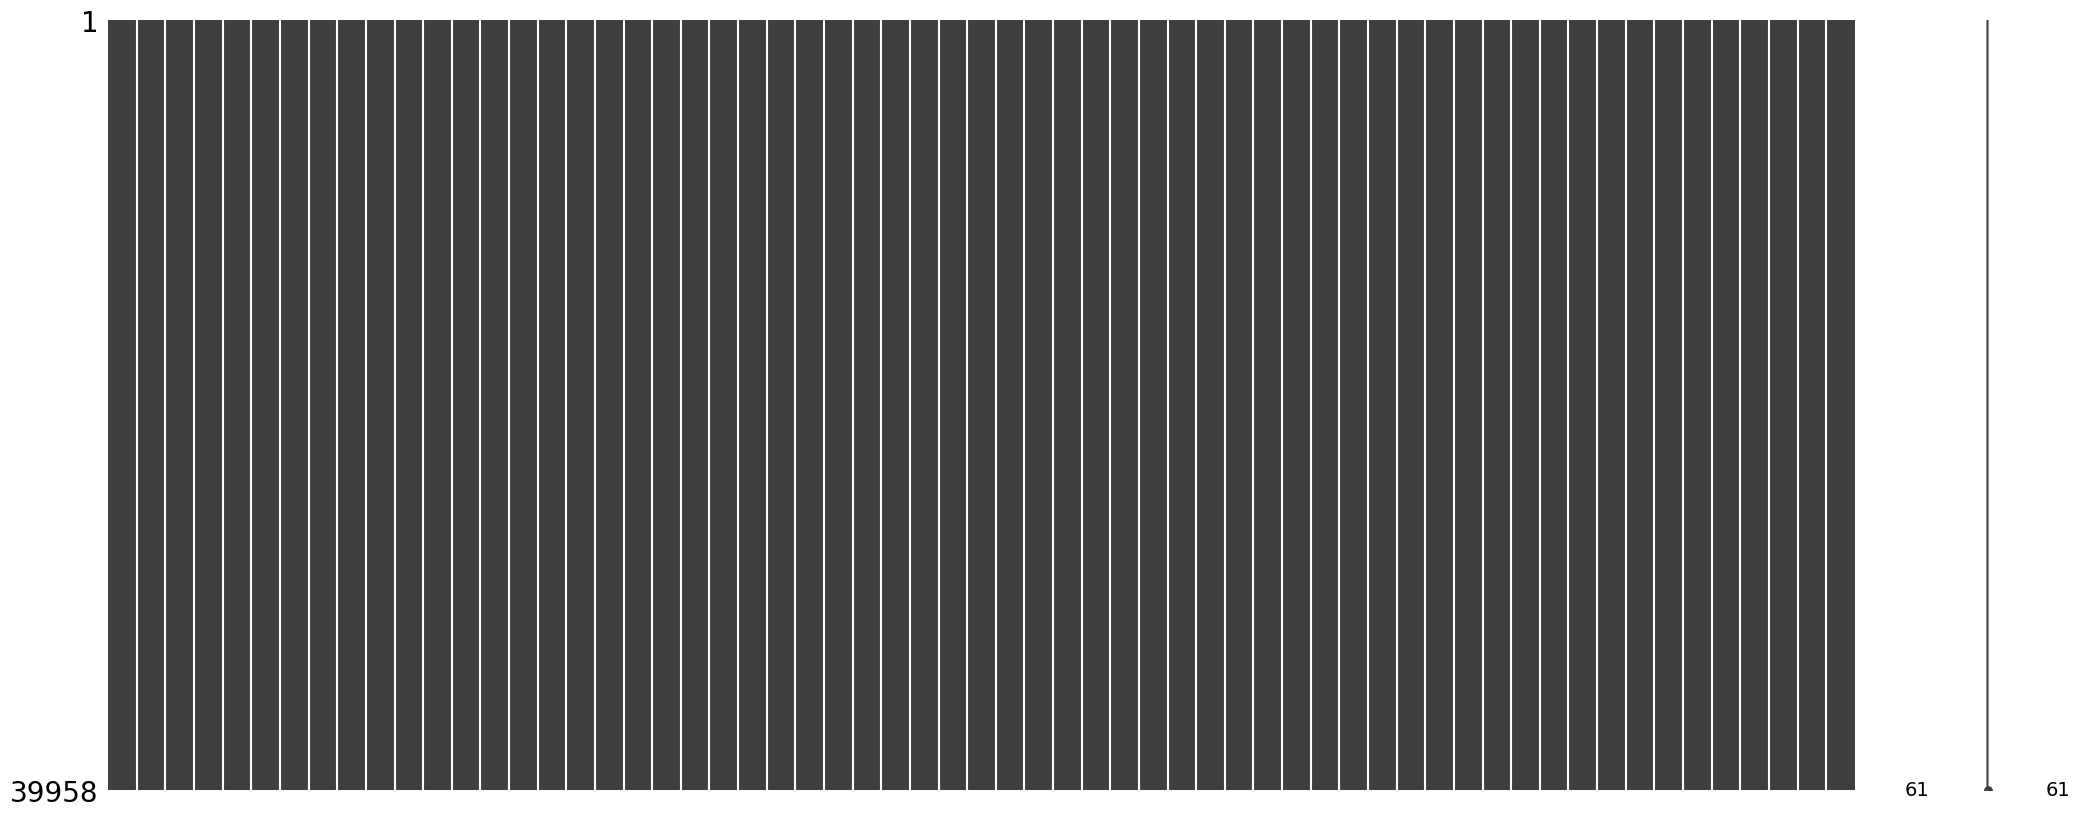

In [19]:
msno.matrix(DataFinalLoad)
